In [1]:
#!pip install -q -U --no-cache-dir \    accelerate \    peft \    transformers \    trl \    datasets \    bitsandbytes

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training
from trl import SFTTrainer
from datasets import load_dataset

print("Libraries re-installed and re-imported.")

Libraries re-installed and re-imported.


In [2]:
# --- Configuration ---
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
output_dir = "./tinyllama_qlora_finetune"

# --- 4-bit Quantization Configuration (QLoRA) ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# --- 1. Load the Quantized Model ---
print(f"Loading model: {model_name}...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

model.config.use_cache = False
# Prepare the model for k-bit training
model = prepare_model_for_kbit_training(model)
model.config.pretraining_tp = 1

# --- 2. Load the Tokenizer ---
print(f"Loading tokenizer: {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Add padding token to the tokenizer if it doesn't have one
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

print("Model and Tokenizer loaded successfully.")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Loading tokenizer: TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Model and Tokenizer loaded successfully.


In [3]:
## 1. Load and Split the Dataset

from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
df = pd.read_csv('./dataset1/Disease precaution.csv')
df1 = pd.read_csv('./dataset1/DiseaseAndSymptoms.csv')
df1 = df1.replace(np.nan, '')
df = df.replace(np.nan, '')

symptoms = [f"Symptom_{x}" for x in range(1,18)]
df1['Symptoms'] = df1.apply(lambda row : ','.join(row[symptoms]).strip(','), axis=1)
df1 = df1[['Disease', 'Symptoms']]
df = df1.merge(df)

disease_counts = df['Disease'].value_counts()

# Identify classes with a count less than the minimum required (which is 2 for a stratified split)
MIN_COUNT_FOR_STRATIFICATION = 2
rare_classes = disease_counts[disease_counts < MIN_COUNT_FOR_STRATIFICATION].index.tolist()

print(f"Total number of diseases before grouping: {len(disease_counts)}")
print(f"Diseases with only 1 sample (to be grouped): {rare_classes}")
print("-" * 50)

# --- 2. Group the Rare Classes ---
# Define the new label for the combined rare group
RARE_GROUP_LABEL = 'Rare_Disease_Group'

# Create a new DataFrame column to hold the grouped labels
df['Disease_Grouped'] = df['Disease'].apply(
    lambda x: RARE_GROUP_LABEL if x in rare_classes else x
)

# Verify the new counts
grouped_counts = df['Disease_Grouped'].value_counts()
print(f"Total number of diseases after grouping: {len(grouped_counts)}")
print(f"Count of '{RARE_GROUP_LABEL}': {grouped_counts.get(RARE_GROUP_LABEL, 0)}")
print("-" * 50)

# --- 3. Perform the Stratified Split with the New Grouped Labels ---

# Define the features and the new target variable (y_grouped)
X = df.drop(columns=['Disease', 'Disease_Grouped'])
y_grouped = df['Disease_Grouped']

# Perform the stratified split using the corrected labels
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_grouped,
    test_size=0.2,
    random_state=42,
    stratify=y_grouped # Use the grouped labels for stratification!
)

# --- 4. Prepare Final Evaluation Dataset ---
# Recombine the test features (X_test) with the grouped label (y_test) for evaluation
test_df_final = pd.DataFrame(X_test).copy()
test_df_final['Disease_Grouped'] = y_test

# Convert the final test DataFrame to a Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df_final.reset_index(drop=True))
df = pd.DataFrame(X_train).copy()
df['Disease'] = y_train
print("Dataset splitting complete. 'test_dataset' is ready for evaluation.")
print(f"Final test set size: {len(test_dataset)}")
df.describe

Total number of diseases before grouping: 41
Diseases with only 1 sample (to be grouped): []
--------------------------------------------------
Total number of diseases after grouping: 41
Count of 'Rare_Disease_Group': 0
--------------------------------------------------
Dataset splitting complete. 'test_dataset' is ready for evaluation.
Final test set size: 984


<bound method NDFrame.describe of                                                Symptoms  \
3374   back_pain, weakness_in_limbs, neck_pain, dizz...   
1432   fatigue, lethargy, yellowish_skin, dark_urine...   
3663  itching, vomiting, fatigue, weight_loss, high_...   
3296  itching, skin_rash, fatigue, lethargy, high_fe...   
3232   joint_pain, neck_pain, knee_pain, hip_joint_p...   
...                                                 ...   
336    vomiting, fatigue, anxiety, headache, nausea,...   
2608   chills, vomiting, fatigue, weight_loss, cough...   
2160   acidity, indigestion, headache, blurred_and_d...   
1449   fatigue, yellowish_skin, nausea, loss_of_appe...   
3604   skin_rash, pus_filled_pimples, blackheads, sc...   

                      Precaution_1              Precaution_2  \
3374  use heating pad or cold pack                  exercise   
1432      consult nearest hospital               vaccination   
3663         drink plenty of water      consume milk thistle   
3

In [4]:
def create_prompt(row):
    """
    Formats a single row into the instruction/response prompt structure.
    """
    symptoms = row['Symptoms']
    disease = row['Disease']

    # Concatenate all non-NaN precaution columns
    precautions = [
        str(row[f'Precaution_{i}'])
        for i in range(1, 5)
        if pd.notna(row[f'Precaution_{i}']) and str(row[f'Precaution_{i}']).lower() != 'nan'
    ]
    precautions_str = ", ".join(precautions)

    # Create the structured prompt
    prompt = f"""### HUMAN:
Symptoms: {symptoms}

### ASSISTANT:
Diagnosis: {disease}
Precautions: {precautions_str}"""

    return prompt

# Apply the function to the DataFrame
df['text'] = df.apply(create_prompt, axis=1)

# Convert the Pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df[['text']])

print("\nExample of the formatted training prompt:")
print(dataset[0]['text'])

print(f"\nTotal number of samples in dataset: {len(dataset)}")

def formatting_func(example):
    # Returns a list of strings, where each string is a fully formatted example
    return example['text'] if isinstance(example['text'], list) else [example['text']]


Example of the formatted training prompt:
### HUMAN:
Symptoms:  back_pain, weakness_in_limbs, neck_pain, dizziness, loss_of_balance

### ASSISTANT:
Diagnosis: Cervical spondylosis
Precautions: use heating pad or cold pack, exercise, take otc pain reliver, consult doctor

Total number of samples in dataset: 3936


In [5]:
import transformers
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
import torch
import warnings

# Suppress the warnings about modifying the model with PEFT
warnings.filterwarnings("ignore", "You are trying to modify a model with PEFT for a second time")
warnings.filterwarnings("ignore", "Already found a `peft_config` attribute in the model")

# --- 1. LoRA Configuration (Required for QLoRA) ---
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)

# Apply the LoRA configuration to the quantized model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# --- 2. Training Arguments (Required) ---
training_arguments = transformers.TrainingArguments(
    output_dir="./tinyllama_qlora_finetune",
    num_train_epochs=2,
    per_device_train_batch_size=1, # Minimal batch size
    gradient_accumulation_steps=4, # Compensate for small batch size
    optim="paged_adamw_8bit",      # QLoRA specific optimizer
    fp16=False,                     # Use half-precision
    bf16 = False,
    logging_steps=10,
    learning_rate=2e-4,
    disable_tqdm=False,
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    args=training_arguments,
    peft_config=lora_config,
)

# --- 4. Start Training ---
print("Starting QLoRA Fine-Tuning...")
trainer.train()

# --- 5. Save the Adapter Weights ---
trainer.save_model("./tinyllama_qlora_finetune")
print(f"Fine-tuning complete. LoRA adapter weights saved to ./tinyllama_qlora_finetune")

trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


C:\Users\surya\.pyenv\pyenv-win\versions\3.12.9\Lib\site-packages\peft\tuners\lora\bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/3936 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3936 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3936 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Starting QLoRA Fine-Tuning...


C:\Users\surya\.pyenv\pyenv-win\versions\3.12.9\Lib\site-packages\torch\_dynamo\eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,2.108200
20,1.396900
30,1.162600
40,0.917100
50,0.826600
60,0.735600
70,0.578500
80,0.506300
90,0.401500
100,0.338900


C:\Users\surya\.pyenv\pyenv-win\versions\3.12.9\Lib\site-packages\torch\_dynamo\eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\surya\.pyenv\pyenv-win\versions\3.12.9\Lib\site-packages\torch\_dynamo\eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two varia

Fine-tuning complete. LoRA adapter weights saved to ./tinyllama_qlora_finetune


In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import warnings

# Suppress Hugging Face warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# Assume model, tokenizer, and output_dir are still loaded successfully from previous steps

# --- Configuration (Redefined for robustness) ---
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
output_dir = "./tinyllama_qlora_finetune"

# --- 1. Define BitsAndBytes Configuration ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# --- 2. Load the Base Model & Tokenizer ---
print(f"Loading base model: {model_name}...")

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
base_model.config.use_cache = False # Disable cache for stability

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# --- 3. Load the PEFT Adapter Weights ---
print(f"Loading and attaching adapter weights from {output_dir}...")
model = PeftModel.from_pretrained(
    base_model,
    output_dir,
    is_trainable=False
)
model.config.use_cache = False
print("Model ready for inference.")

# --- 4. Run Inference Test with Disclaimer ---

def generate_diagnosis_with_disclaimer(symptoms: str):
    """Generates a diagnosis, explanation, and appends the required disclaimer."""

    # Define the required disclaimer
    DISCLAIMER = "\nNote: This is not medical or diagnostic advice. Consult a real doctor for health issues."

    # Adjust System Prompt to enforce the new "Possible condition" and "Explanation" fields
    system_prompt = (
        "You are an expert medical pattern recognition assistant. "
        "Your task is to identify the Possible condition and provide an Explanation based "
        "on the symptoms provided and the dataset knowledge. "
        "DO NOT include 'Diagnosis:' or 'Precautions:' tags. "
        "Start your response ONLY with 'Possible condiƟon:'"
    )

    prompt = f"""### SYSTEM:
{system_prompt}

### HUMAN:
Symptoms: {symptoms}

### ASSISTANT:
Possible condition:""" # Priming the model for the exact start


    device = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=True,
            top_p=0.8,
            temperature=0.6,
            repetition_penalty=1.15,
            eos_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Clean up the response (Extract only the model's output after the prompt)
    if "### ASSISTANT:" in response:
        response = response.split("### ASSISTANT:")[1].strip()

        # Ensure it starts with the primed text
        if not response.startswith("Possible condition:"):
             response = "Possible condition:" + response

    # Append the required disclaimer at the very end
    return response + DISCLAIMER

# --- Test Case ---
test_symptoms = "Fever, headache, body pain"
print("\n" + "=" * 50)
print(f"Test Symptoms: {test_symptoms}")
print("=" * 50)

# Generate the response
diagnosis = generate_diagnosis_with_disclaimer(test_symptoms)

print(f"Generated Output:\n{diagnosis}")
print("=" * 50)

Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Loading and attaching adapter weights from ./tinyllama_qlora_finetune...
Model ready for inference.

Test Symptoms: Fever, headache, body pain
Generated Output:
Possible condition: Chicken pox
Precautions: use neem in bathing , avoid public places during vaccination time, keep chickens away from children
Note: This is not medical or diagnostic advice. Consult a real doctor for health issues.


In [6]:
## 2. Helper Function for Prediction

import re
from tqdm.auto import tqdm
import torch

# Ensure 'tokenizer' and 'model' are loaded in memory from previous steps

def extract_prediction(model_output: str) -> str:
    """
    Cleans and extracts the predicted disease name from the model's structured output.
    """
    # Look for the pattern "Possible condition: [DISEASE NAME] (from dataset)"
    match = re.search(r'Possible condition:\s*(.*?)(?:\s*\(from dataset\))?[\n\r]', model_output, re.DOTALL)

    if match:
        predicted_disease = match.group(1).strip().lower()
        if '\n' in predicted_disease:
            predicted_disease = predicted_disease.split('\n')[0]

        # Optional: Remove any trailing explanatory text that bled through
        if 'explanation' in predicted_disease:
             predicted_disease = predicted_disease.split('explanation')[0].strip()

        return predicted_disease

    # Fallback: Simple extraction
    return model_output.split(':')[0].strip().lower() if ':' in model_output else model_output.strip().lower()

def get_model_prediction(sample_text: str) -> str:
    """Runs the inference and returns the cleaned, predicted disease."""

    # Use the same forced prompt format as the last successful generation
    prompt = f"""### SYSTEM:
You are an expert medical pattern recognition assistant. Your task is to identify the Possible condition and provide an Explanation based on the symptoms provided. DO NOT include 'Diagnosis:' or 'Precautions:' tags. Start your response ONLY with 'Possible condiƟon:'

### HUMAN:
Symptoms: {sample_text}

### ASSISTANT:
Possible condition:"""

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Ensure inputs are correctly tokenized using the global 'tokenizer'
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        # Ensure 'model' is the globally loaded PeftModel
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False, # Deterministic prediction
            temperature=0.1,
            repetition_penalty=1.1,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract the disease name using the helper function
    return extract_prediction(response)

print("Prediction helper functions (extract_prediction and get_model_prediction) are now defined.")

Prediction helper functions (extract_prediction and get_model_prediction) are now defined.


In [16]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# --- Configuration (Must match the training setup) ---
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
adapter_path = "./tinyllama_qlora_finetune" # The folder where trainer.save_model() saved the weights

# --- 1. Define the Quantization Config (Crucial for QLoRA loading) ---
# This configuration must be the same as the one used during training.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16, # Match the training dtype
)

# --- 2. Load the Base Model ---
print(f"Loading base model: {model_name}...")
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Load base model with QLoRA configuration
    device_map="auto",
    trust_remote_code=True,
)

# --- 3. Load the Tokenizer ---
print(f"Loading tokenizer: {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# --- 4. Attach the LoRA Adapter Weights ---
print(f"Loading and attaching LoRA adapters from: {adapter_path}...")
model = PeftModel.from_pretrained(
    base_model,
    adapter_path,
)

# --- 5. (Optional but Recommended) Merge and Unload the Model ---
# This step combines the base model weights and the LoRA adapter weights 
# into a single, cohesive model. This is often better for performance 
# and for saving a final, merged model file.
print("Merging adapters into the base model...")
model = model.merge_and_unload() 

print("Fine-tuned model loaded successfully and ready for inference.")



Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Loading tokenizer: TinyLlama/TinyLlama-1.1B-Chat-v1.0...
Loading and attaching LoRA adapters from: ./tinyllama_qlora_finetune...
Merging adapters into the base model...
Fine-tuned model loaded successfully and ready for inference.



Generating predictions for the test set...


  0%|          | 0/984 [00:00<?, ?it/s]


--- Classification Report ---
                                                            precision    recall  f1-score   support

                   (vertigo) paroymsal  positional vertigo       0.00      0.00      0.00         3
                                                      acne       1.00      0.50      0.67         2
                             acute coronary syndrome (acs)       0.00      0.00      0.00         0
acute gastroenteritis (diarrhea, vomiting, abdominal pain)       0.00      0.00      0.00         0
                                       acute heart failure       0.00      0.00      0.00         0
                                         acute hepatitis c       0.00      0.00      0.00         0
                                acute kidney failure (akf)       0.00      0.00      0.00         0
                                 acute kidney injury (aki)       0.00      0.00      0.00         0
                                       acute liver failure       0.0

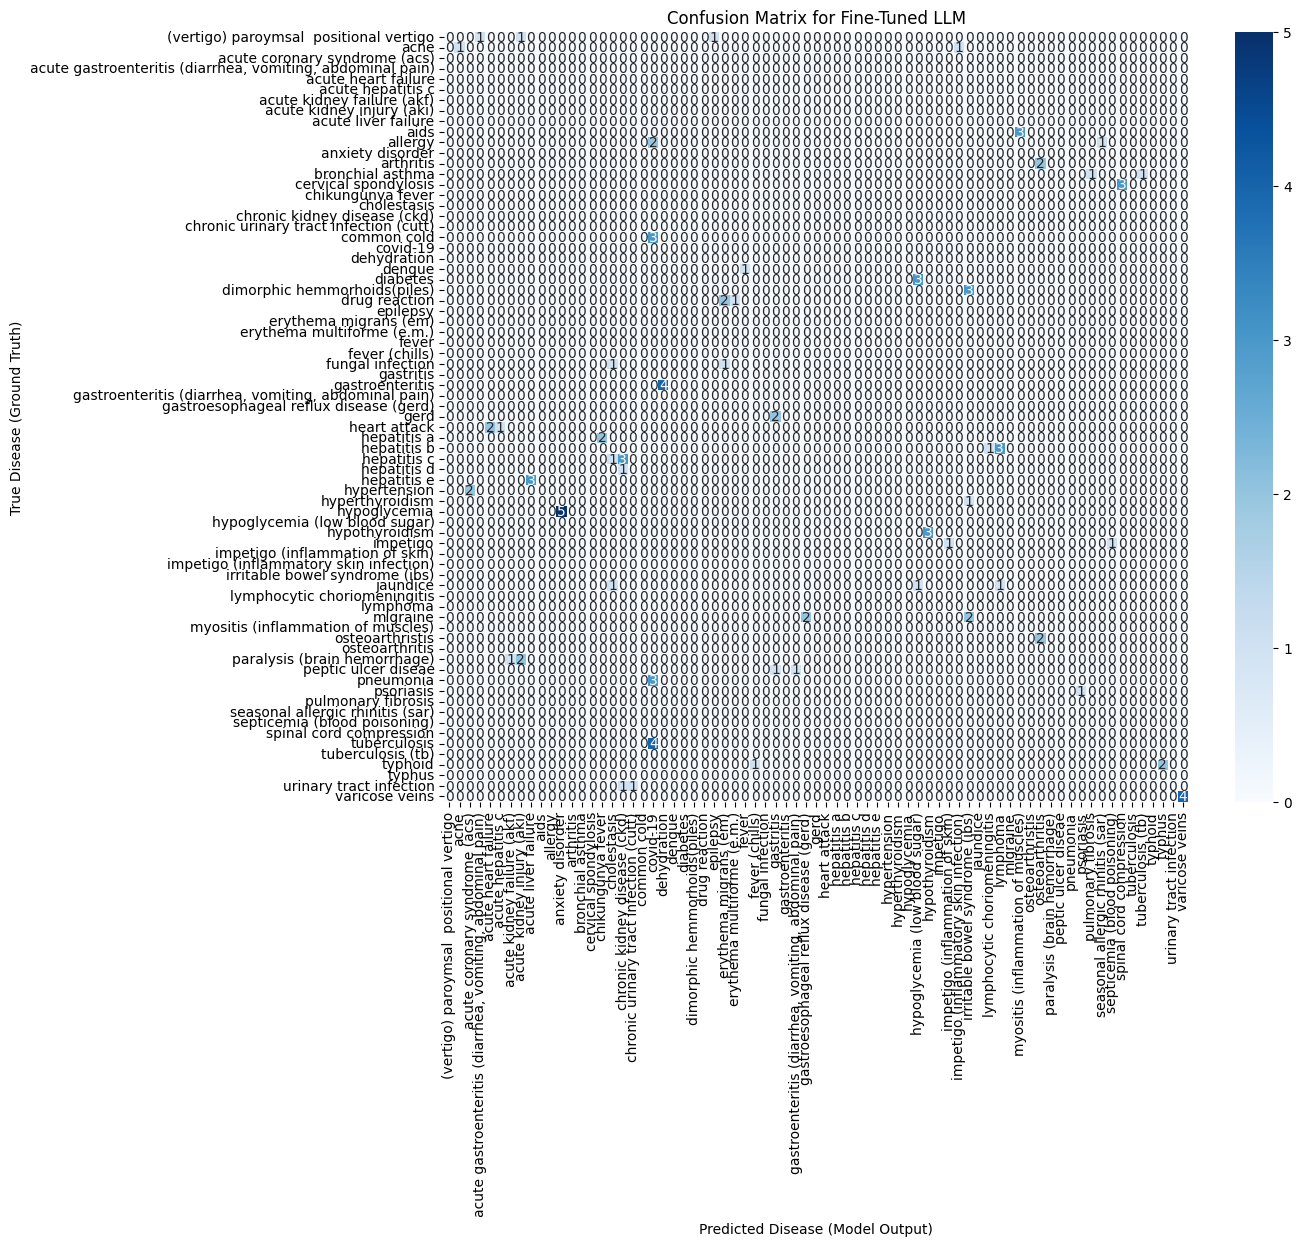


Evaluation complete. Check the plot and the classification report.


In [10]:
## 3. Generate Predictions and Calculate Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm # Ensure tqdm is imported

# Lists to store ground truth and predictions
y_true = []
y_pred = []

# Iterate over the test dataset
i = 0
print("\nGenerating predictions for the test set...")
for sample in tqdm(test_dataset):
    
    if i==100:
        break
    i+=1
    symptoms = sample['Symptoms']

    predicted_disease = get_model_prediction(symptoms)
    
    true_disease = sample['Disease_Grouped'].strip().lower()
    if true_disease.startswith("'") and true_disease.endswith("'"):
         true_disease = true_disease.strip("'")

    y_true.append(true_disease)
    y_pred.append(predicted_disease)

# --- Classification Report and Confusion Matrix ---

all_labels = sorted(list(set(y_true + y_pred)))

cm = confusion_matrix(y_true, y_pred, labels=all_labels)

# Print the Classification Report (Accuracy, F1-score, Recall)
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

# Plot the Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=all_labels,
    yticklabels=all_labels
)
plt.title('Confusion Matrix for Fine-Tuned LLM')
plt.ylabel('True Disease (Ground Truth)')
plt.xlabel('Predicted Disease (Model Output)')
plt.show()

print("\nEvaluation complete. Check the plot and the classification report.")

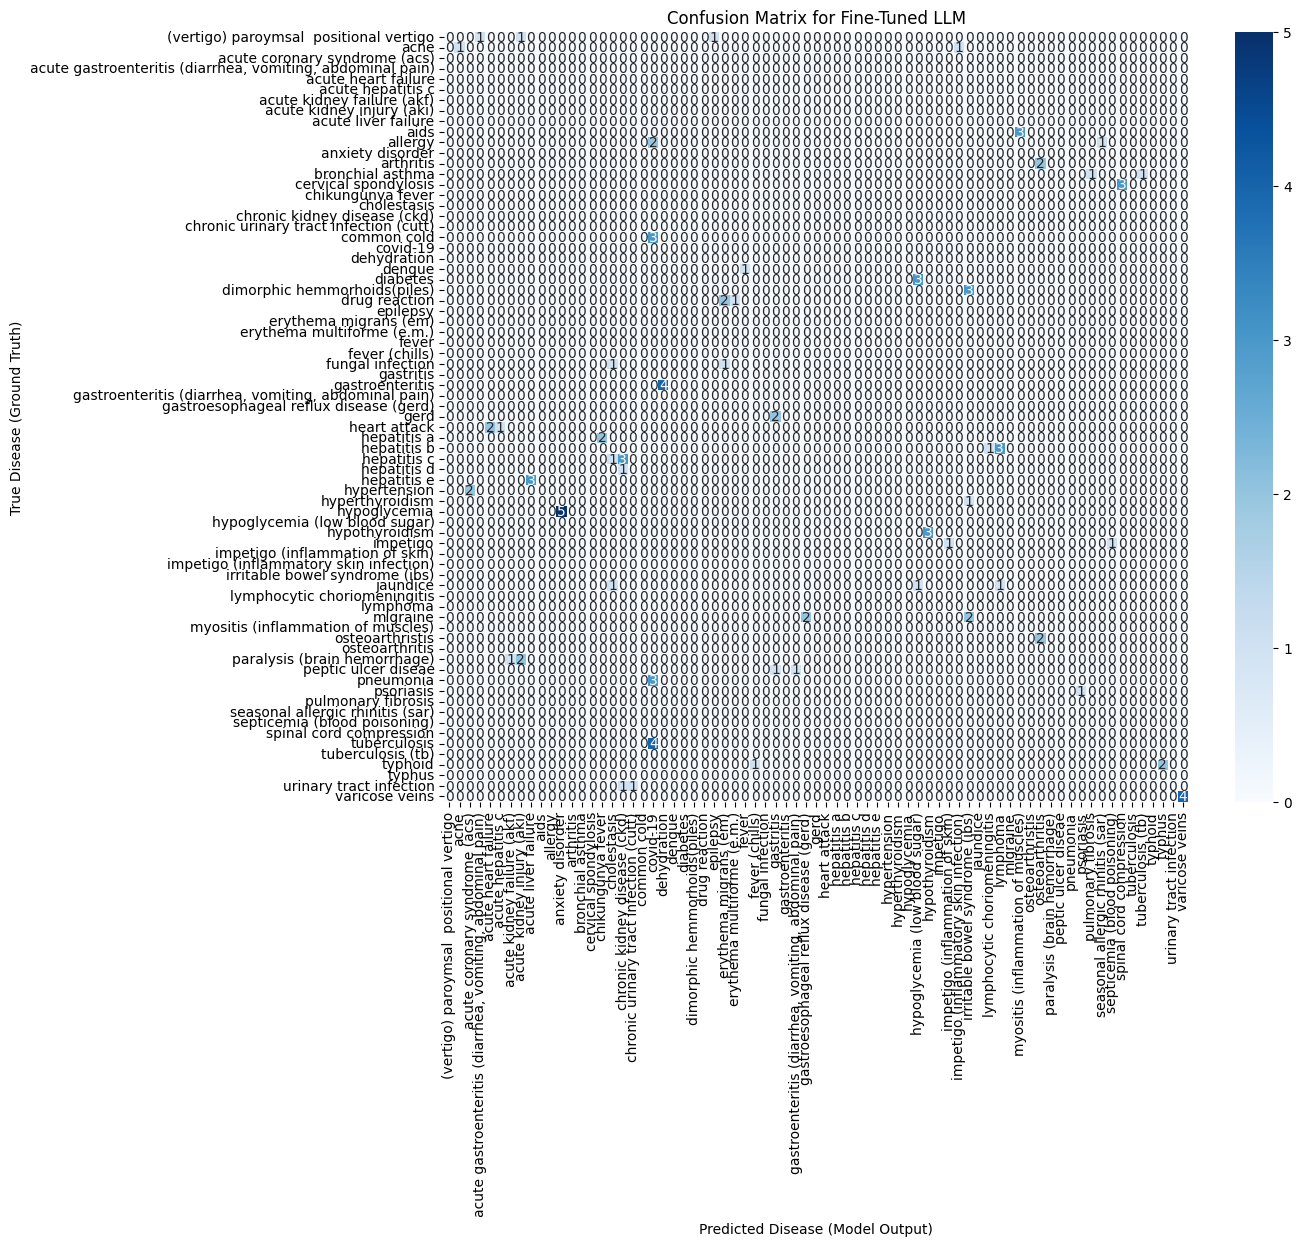

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=all_labels,
    yticklabels=all_labels
)
plt.title('Confusion Matrix for Fine-Tuned LLM')
plt.ylabel('True Disease (Ground Truth)')
plt.xlabel('Predicted Disease (Model Output)')
plt.savefig("ConfusionMatrixDiseases.png")

In [21]:
# --- Example Inference ---
prompt = "Fever, headache, body pain "
inputs = tokenizer(prompt, return_tensors="pt").to("cuda") # Ensure input is on GPU

with torch.no_grad():
    outputs = generate_diagnosis_with_disclaimer(prompt)
print("\n--- Model Response ---")
print(outputs)
print("-----------------------")


--- Model Response ---
Possible condition: Influenza (Flu)
Explanation: Based on the symptoms provided, I conclude that you may have been infected by influenza (flu). Flu is a viral infection spread through respiratory droplets. Symptoms of flu can include fever, cough, sore throat, runny nose, muscle pain, fatigue, and swollen lymph nodes (lymphadenopathy). The disease has caused many deaths worldwide due to its severity and complications. Precautions: Wash hands frequently with soap and water for at least 20 seconds, avoid touching your face, cover your mouth when you cough or sneeze, stay away from sick people, and get vaccinated if recommended by your doctor.
Note: This is not medical or diagnostic advice. Consult a real doctor for health issues.
-----------------------


In [19]:
# --- Example Inference ---
prompt = "Fever, headache, cold "
inputs = tokenizer(prompt, return_tensors="pt").to("cuda") # Ensure input is on GPU

with torch.no_grad():
    outputs = generate_diagnosis_with_disclaimer(prompt)
print("\n--- Model Response ---")
print(outputs)
print("-----------------------")


--- Model Response ---
Possible condition: Viral infection (Fever)
Explanation: Based on the symptoms provided, it can be inferred that a viral infection (fever) could have caused this condition. The disease may manifest through fever, headache, and chills. Precautions: Consult a healthcare professional immediately if you experience severe or prolonged pain in any part of your body, such as back, neck, or joints.
Note: This is not medical or diagnostic advice. Consult a real doctor for health issues.
-----------------------


In [15]:
# --- Example Inference ---
prompt = "Fever, headache, coughs "
inputs = tokenizer(prompt, return_tensors="pt").to("cuda") # Ensure input is on GPU

with torch.no_grad():
    outputs = generate_diagnosis_with_disclaimer(prompt)
print("\n--- Model Response ---")
print(outputs)
print("-----------------------")


--- Model Response ---
Possible condition: Viral infection (COVID-19)
Explanation: According to the symptoms given, it's highly likely that you have COVID-19. The fever, coughs, and fatigue can all be signs of the disease. You should self-isolate for at least 14 days and get tested if you develop any severe symptoms. Wear a mask when around others to prevent spreading the virus. Follow social distancing guidelines and avoid large gatherings. Stay up-to-date with the latest news about the pandemic to stay informed.
Note: This is not medical or diagnostic advice. Consult a real doctor for health issues.
-----------------------
